In [1]:
# Check for CUDA availability and set the device
import torch
import os

# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print device information
print(f"Using device: {device}")
if is_cuda_available:
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    # Set CUDA device visibility if needed
    # os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using device: cuda
CUDA Device: NVIDIA GeForce RTX 4070
CUDA Version: 12.8


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nojedag/finbert-finetuned-financial-news-sentiment-analysis-european")
model = AutoModelForSequenceClassification.from_pretrained("nojedag/finbert-finetuned-financial-news-sentiment-analysis-european")

# Move model to the appropriate device (GPU if available)
model = model.to(device)
print(f"Model moved to {device}")

Model moved to cuda


In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": (preds == labels).mean(),
    }

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

def get_preds_and_labels(eval_output):
    logits = eval_output.predictions
    labels = eval_output.label_ids
    preds = np.argmax(logits, axis=1)
    return preds, labels

TARGET_LABELS = ["neutral", "positive", "negative"]

In [4]:
from datasets import load_dataset
dataset = load_dataset("nojedag/financial_phrasebank_multilingual_augmented")
# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [5]:
from transformers import Trainer, TrainingArguments

# 4. Initialize Trainer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        per_device_eval_batch_size=32,
        output_dir="./results",
        do_eval=True,
        no_cuda=not is_cuda_available,  # Use CUDA if available
        fp16=True,  # Enable mixed precision training
    ),
    compute_metrics=compute_metrics,
)

In [6]:
# 8. Plot it
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(title)
    plt.show()

In [7]:
# Utility functions for language-specific evaluation

def evaluate_language(trainer, tokenized_dataset, lang_code, lang_name):
    """
    Evaluate model performance for a specific language.
    
    Args:
        trainer: The Transformers Trainer object
        tokenized_dataset: The tokenized dataset
        lang_code: Integer code for the language (0=English, 1=French, 2=German, 3=Spanish)
        lang_name: String name of the language for display
    
    Returns:
        tuple: (predictions, labels, confusion_matrix)
    """
    # Filter dataset for specific language
    filtered_dataset = tokenized_dataset["test"].filter(lambda x: x["lang"] == lang_code)
    
    # Run evaluation
    eval_output = trainer.predict(filtered_dataset)
    preds, labels = get_preds_and_labels(eval_output)
    
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, [0, 1, 2], title=f"{lang_name} Confusion Matrix")
    
    # Print classification report
    print(f"\n{lang_name} Classification Report:")
    print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"]))
    
    return preds, labels, cm

def evaluate_all_languages(trainer, tokenized_dataset):
    """
    Evaluate model performance for all languages.
    
    Args:
        trainer: The Transformers Trainer object
        tokenized_dataset: The tokenized dataset
    
    Returns:
        dict: Results for each language
    """
    languages = {
        0: "English",
        1: "French", 
        2: "German",
        3: "Spanish"
    }
    
    results = {}
    
    for lang_code, lang_name in languages.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {lang_name} samples")
        print(f"{'='*50}")
        
        preds, labels, cm = evaluate_language(trainer, tokenized_dataset, lang_code, lang_name)
        results[lang_name] = {
            'predictions': preds,
            'labels': labels,
            'confusion_matrix': cm
        }
    
    return results

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nestorojedagonzalez (nojeda) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


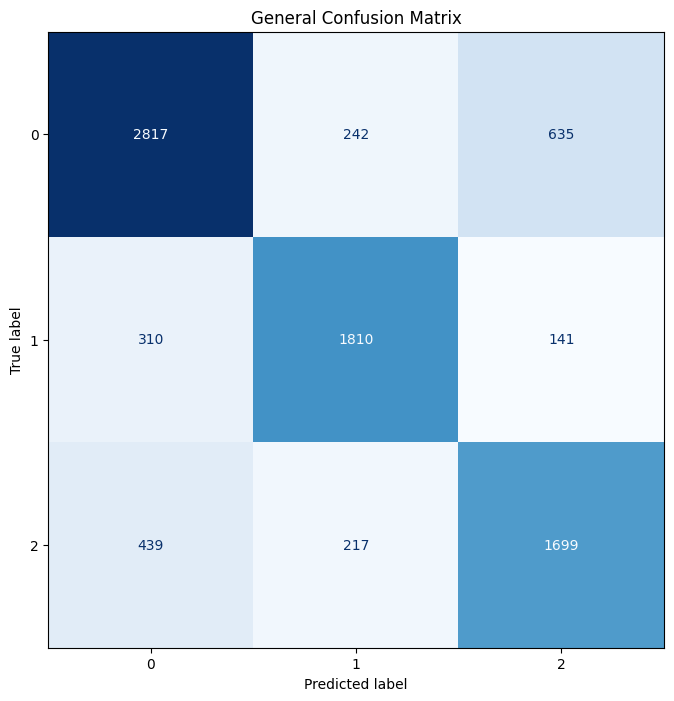

In [8]:
# 5. Run evaluation to get raw preds & labels
eval_output = trainer.predict(tokenized_dataset["test"])
preds, labels = get_preds_and_labels(eval_output)
# 7. Compute confusion matrix
cm = confusion_matrix(labels, preds)
# If you want normalized counts, pass `normalize='true'` or `normalize='pred'` etc.
plot_confusion_matrix(cm, [0, 1, 2], title="General Confusion Matrix")

In [9]:
# Overall evaluation with F1 score, recall, precision
from sklearn.metrics import classification_report
print("Overall Classification Report:")
print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"]))

Overall Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.76      0.78      3694
     neutral       0.80      0.80      0.80      2261
    positive       0.69      0.72      0.70      2355

    accuracy                           0.76      8310
   macro avg       0.76      0.76      0.76      8310
weighted avg       0.76      0.76      0.76      8310




Evaluating English samples


Filter:   0%|          | 0/8310 [00:00<?, ? examples/s]

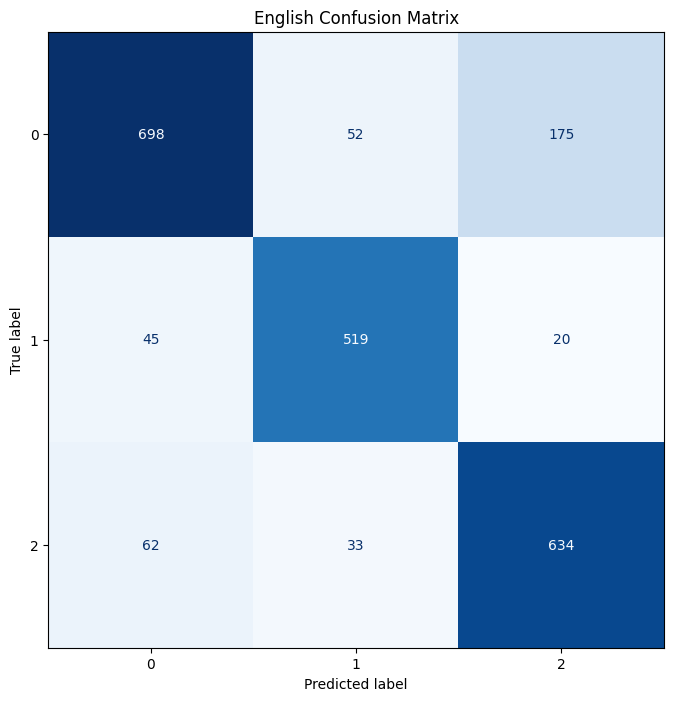


English Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.75      0.81       925
     neutral       0.86      0.89      0.87       584
    positive       0.76      0.87      0.81       729

    accuracy                           0.83      2238
   macro avg       0.83      0.84      0.83      2238
weighted avg       0.83      0.83      0.83      2238


Evaluating French samples


Filter:   0%|          | 0/8310 [00:00<?, ? examples/s]

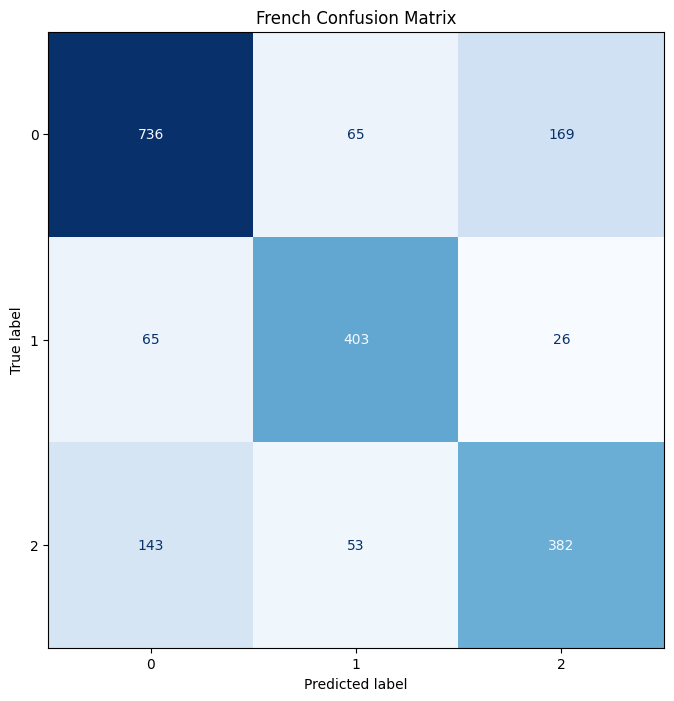


French Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.76      0.77       970
     neutral       0.77      0.82      0.79       494
    positive       0.66      0.66      0.66       578

    accuracy                           0.74      2042
   macro avg       0.74      0.75      0.74      2042
weighted avg       0.74      0.74      0.74      2042


Evaluating German samples


Filter:   0%|          | 0/8310 [00:00<?, ? examples/s]

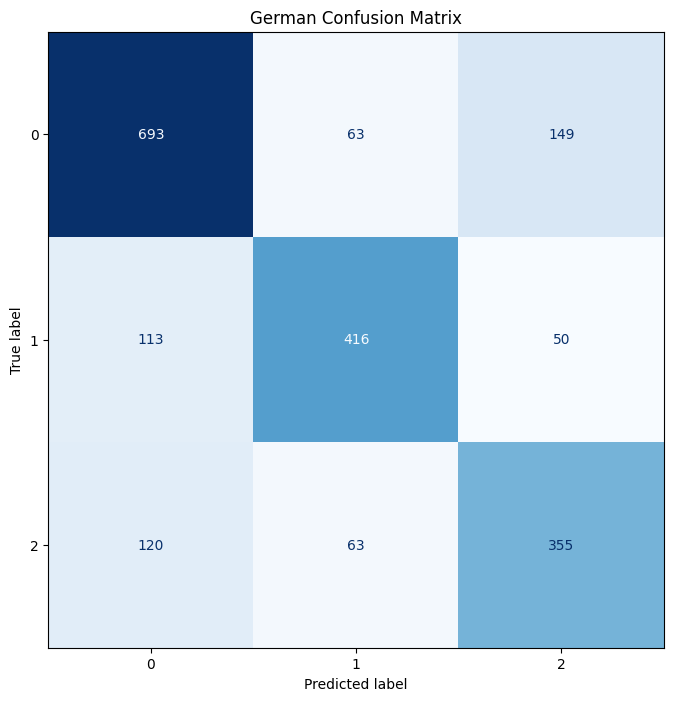


German Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.77      0.76       905
     neutral       0.77      0.72      0.74       579
    positive       0.64      0.66      0.65       538

    accuracy                           0.72      2022
   macro avg       0.72      0.71      0.72      2022
weighted avg       0.73      0.72      0.72      2022


Evaluating Spanish samples


Filter:   0%|          | 0/8310 [00:00<?, ? examples/s]

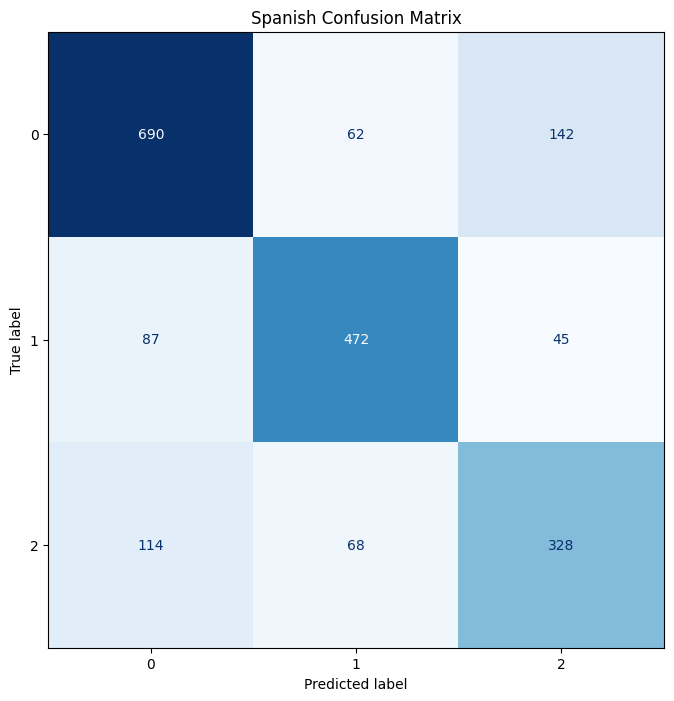


Spanish Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.77      0.77       894
     neutral       0.78      0.78      0.78       604
    positive       0.64      0.64      0.64       510

    accuracy                           0.74      2008
   macro avg       0.73      0.73      0.73      2008
weighted avg       0.74      0.74      0.74      2008



In [10]:
# Evaluate model performance for all languages using the utility functions
language_results = evaluate_all_languages(trainer, tokenized_dataset)